TODO: Documentation of functions from feature_utils

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import os

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import threshold_otsu
from skimage.morphology import dilation, erosion
from skimage.transform import resize

from feature_utils import (get_gray_hist, rgb_stats,
                              vessels_area, disc_area,
                              hsv_stats, rgb_equalize_hist_stats)

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

%load_ext autoreload
%autoreload 2


In [6]:
from IPython.display import HTML, display
import pprint
pp = pprint.PrettyPrinter(indent=4, width=100)


HTML('''
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}''')

# Eye-eye P: Ocular Disease Classification

![Title](resources/title.gif)

# Executive Summary

TODO: Exec summary.

# Introduction

Vision is one of the most essential senses of human beings. Majority of our day-to-day activities heavily depend on our sense of sight. Unfortunately, in a 2019 World Health Organization report, an estimated count of 2.2 billion people around the world suffer from vision impairment. In the Philippines, the Health Department reported around 2 million Filipinos with varied eye conditions, where 55% are suffering from eye cataract and 2 out of 5 Filipinos having myopia (Romualdez, 2019). In the same report, it was also stated that these cases would continue to shoot up to 50% by 2030 (Madarang, 2019). With these in mind, the team hopes to aid our health practitioners in diagnosing these conditions by leveraging the learned techniques from Introduction to Image Processing and Machine Learning.

# Problem Statement

![Problem Statement](resources/problemstatement.gif)

# Significance of the Study

TODO: Significance of the Study

# Dataset

## Background

The dataset used in this study is the **Ocular Disease Intelligent Recognition** (ODIR) dataset. ODIR is an ophthalmic database of 5000 patients containing eye-related information such as patient age, color fundus photographs from left and right eyes, and doctors' diagnostic keywords for each eye. 

## Download the Dataset

In [7]:
# Run in terminal
# kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

In [8]:
# Unzip the file
# !unzip ocular-disease-recognition-odir5k.zip

TODO: Explain the folder structure of the dataset.

## Data Description

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

    Normal (N),
    Diabetes (D),
    Glaucoma (G),
    Cataract (C),
    Age related Macular Degeneration (A),
    Hypertension (H),
    Pathological Myopia (M),
    Other diseases/abnormalities (O)
    
Reference: https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k

TODO: Explain that we only used Normal, Cataract and Pathological Myopia. 

# Methodology

TODO: Explain Overview of methodology.

IP = Image Processing

1. EDA
2. IP Classifier
    1. IP Feature Engineering
    2. Modelling
3. CNN Classifier
    1. Modelling using Keras
3. CNN Classifier using VGG-19

<img src = 'resources/methodology.gif' height = 1200 width = 1700 />

The study employs the methodology stipulated above. The analysis kicks-off after collecting fundus photographs from the data source - Kaggle. To know more about the data (e.g. target class distribution, among others), an exploratory data Analysis is implemented. Then, in order to have features to feed our machine learning models, feature extraction is done through the use of image processing techniques. Finally, classification modeling using traditional supervised algorithms and convolutional deep learning models is implemented. 

## EDA
TODO: Simple EDA to show distribution of classes and simple counts?? Distribution of ages also?

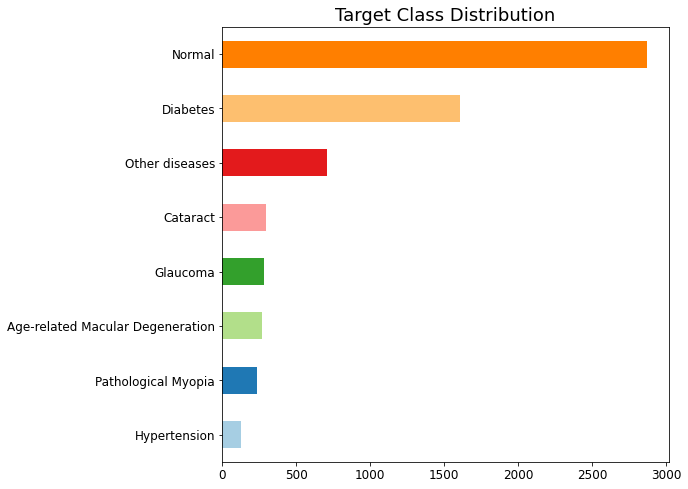

In [37]:
df = pd.read_csv("full_df.csv")

classes = {'[\'N\']':'Normal',
           '[\'D\']':'Diabetes',
           '[\'O\']':'Other diseases',
           '[\'C\']':'Cataract',
           '[\'G\']':'Glaucoma',
           '[\'A\']':'Age-related Macular Degeneration',
           '[\'M\']':'Pathological Myopia',
           '[\'H\']':'Hypertension'
           }

df = df.replace({"labels": classes})

plt.subplots(figsize=(8,8))
plt.tick_params(labelsize=12)
df['labels'].value_counts().sort_values().plot(kind='barh', 
                            color=plt.cm.Paired(np.arange(len(df))))
plt.title('Target Class Distribution', size = 18);

### Loading the Data

In [9]:
df = pd.read_csv("full_df.csv")
# Important Features
features = ['ID', 'Patient Age', 'Patient Sex', 
            'labels', 'filename']
df = df[features]
df['labels'] = df['labels'].str[2:3]
df['filepath'] = 'preprocessed_images/' + df['filename']
df = df[df['labels'].isin(['N', 'C', 'M'])].copy()
df = df.reset_index(drop=True)
df.head()

,ID,Patient Age,Patient Sex,labels,filename,filepath
0,0,69,Female,N,0_right.jpg,preprocessed_images/0_right.jpg
1,1,57,Male,N,1_right.jpg,preprocessed_images/1_right.jpg
2,8,59,Male,N,8_right.jpg,preprocessed_images/8_right.jpg
3,10,70,Male,N,10_right.jpg,preprocessed_images/10_right.jpg
4,13,60,Female,M,13_right.jpg,preprocessed_images/13_right.jpg


## IP Classifier: Classifier with Features from Image Processing

### Feature Engineering

#### Feature 1: Grayscale Histogram Features
We got the got the grayscale intensities and binned them using a histogram. We saved the bin frequencies and bin edges as features. 

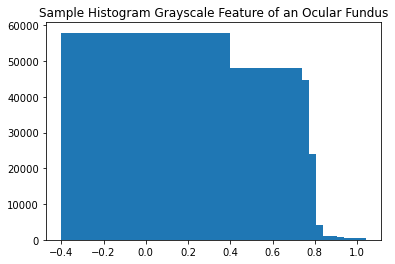

In [10]:
idx = 24
image = imread(df.iloc[idx]['filepath'])
image = rgb2gray(image)
image_flat = image.flatten()
count, bins = np.histogram(image_flat, bins=20)
bins = bins[:-1]
plt.bar(bins, count)
plt.title('Sample Histogram Grayscale Feature of an Ocular Fundus');

In [6]:
df = get_gray_hist(df)

100%|██████████| 3398/3398 [00:54<00:00, 62.06it/s]


#### Feature 2: RGB Statistics
TODO: Explain

In [8]:
df = rgb_stats(df)
df = rgb_equalize_hist_stats(df)

100%|██████████| 3398/3398 [01:00<00:00, 56.20it/s]


#### Feature 3: HSV Statistics
TODO: Explain

In [9]:
df = hsv_stats(df)

100%|██████████| 3398/3398 [05:30<00:00, 10.28it/s]


#### Feature 3: Vessel Area
TODO: Explain

In [12]:
df = vessels_area(df)

100%|██████████| 3398/3398 [00:28<00:00, 118.92it/s]


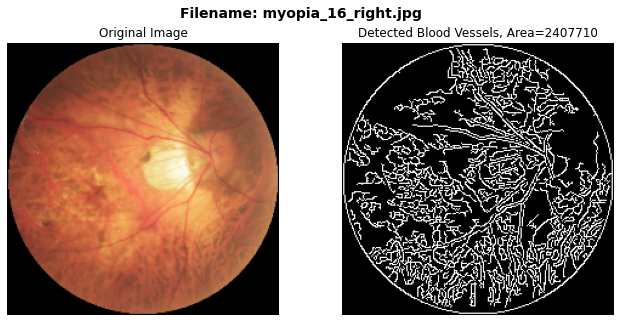

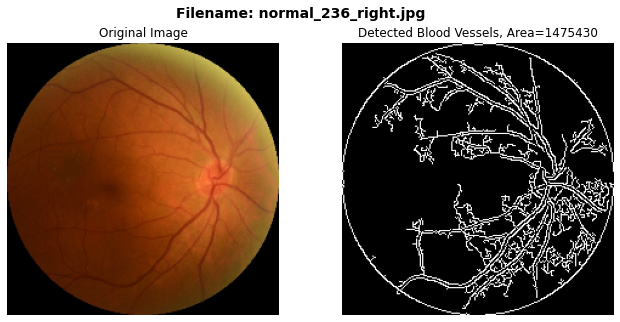

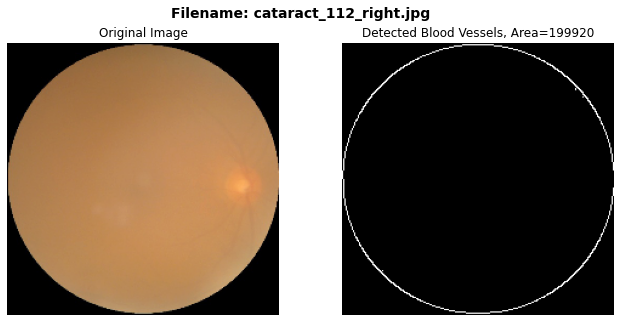

In [11]:
from skimage.morphology import dilation, erosion

def visualize_vessels_path(path):
    """Visualize an image after applying Canny Edge Detection
    """
    filename = path.split('/')[1]
    image = imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                              norm_type = cv2.NORM_MINMAX, 
                              dtype =cv2.CV_8U)

    img_can = cv2.Canny(image,20,125)
    
    
    fig, ax = plt.subplots(1,2, figsize=(11,5))
    ax = ax.flatten()
    
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    ax[1].axis('off')
    ax[1].set_title(f'Detected Blood Vessels, Area={img_can.sum()}')
    ax[1].imshow(img_can, cmap='gray')
    
    plt.suptitle("Filename: "+filename, weight='bold', size=14)
    plt.show()
    
for file in os.listdir('subset'):
    visualize_vessels_path('subset/'+file)

#### Feature 4: Disc Area
We extracted the disc area using canny edge detection then filing the discs using drawCountours. 

In [15]:
df = disc_area(df)

100%|██████████| 3398/3398 [01:04<00:00, 52.64it/s]


Below are samples with extracted disc areas. 

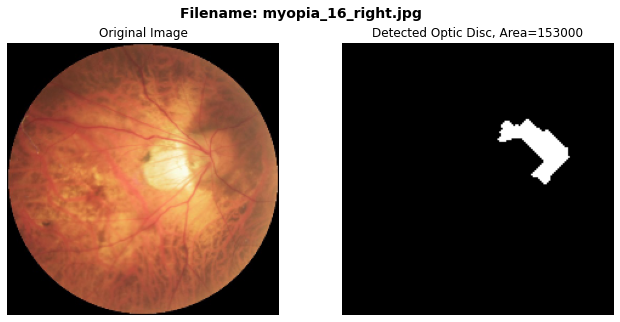

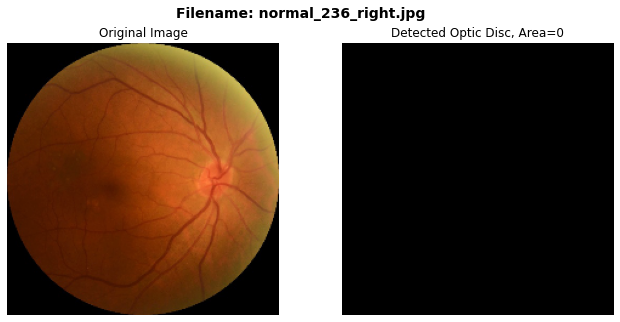

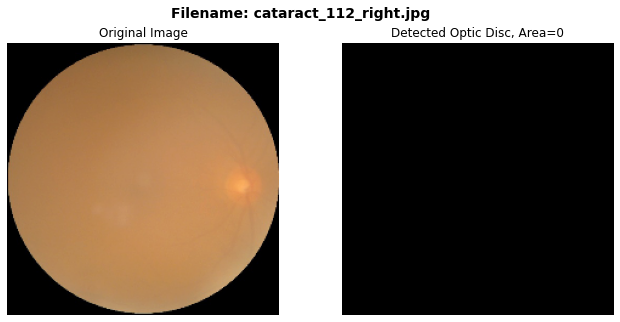

In [12]:
def visualize_discs_path(path):
    """Visualize disc area an image after applying Canny Edge Detection
    """
    filename = path.split('/')[1]
    
    image = imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.normalize(image, None, alpha = 0, beta = 255, 
                              norm_type = cv2.NORM_MINMAX, 
                              dtype =cv2.CV_8U)
    img_can = cv2.Canny(image, 135, 150)
    
    img_can = dilation(erosion(erosion(dilation(dilation(dilation(
        img_can))))))
    
    img_can = img_can[35:189,35:189]
    
    cnts = cv2.findContours(img_can, cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(img_can,[c], 0, (255,), -1)
    
    for i in range(10):
        img_can = erosion(img_can)
    
    
    fig, ax = plt.subplots(1,2, figsize=(11, 5))
    ax = ax.flatten()
    
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    ax[1].axis('off')
    ax[1].set_title(f'Detected Optic Disc, Area={img_can.sum()}')
    ax[1].imshow(img_can, cmap='gray')
    
    
    plt.suptitle("Filename: "+filename, weight='bold', size=14)
    plt.show()
    
for file in os.listdir('subset'):
    visualize_discs_path('subset/'+file)

#####  All Features

In [13]:
# df.to_csv('results.csv.gz')
df = pd.read_csv('results.csv.gz')

with pd.option_context('display.max_columns', None):
    display(df.head(2))
df.columns

,Unnamed: 0,ID,Patient Age,Patient Sex,labels,filename,filepath,gray_hist_count_0,gray_hist_count_1,gray_hist_count_2,gray_hist_count_3,gray_hist_count_4,gray_hist_count_5,gray_hist_count_6,gray_hist_count_7,gray_hist_count_8,gray_hist_count_9,gray_hist_count_10,gray_hist_count_11,gray_hist_count_12,gray_hist_count_13,gray_hist_count_14,gray_hist_count_15,gray_hist_count_16,gray_hist_count_17,gray_hist_count_18,gray_hist_count_19,gray_hist_bin_edges_0,gray_hist_bin_edges_1,gray_hist_bin_edges_2,gray_hist_bin_edges_3,gray_hist_bin_edges_4,gray_hist_bin_edges_5,gray_hist_bin_edges_6,gray_hist_bin_edges_7,gray_hist_bin_edges_8,gray_hist_bin_edges_9,gray_hist_bin_edges_10,gray_hist_bin_edges_11,gray_hist_bin_edges_12,gray_hist_bin_edges_13,gray_hist_bin_edges_14,gray_hist_bin_edges_15,gray_hist_bin_edges_16,gray_hist_bin_edges_17,gray_hist_bin_edges_18,gray_hist_bin_edges_19,gray_hist_bin_edges_20,r_mean,g_mean,b_mean,r_med,g_med,b_med,r_std,g_std,b_std,r_max,g_max,b_max,r_mean_eq,g_mean_eq,b_mean_eq,r_med_eq,g_med_eq,b_med_eq,r_std_eq,g_std_eq,b_std_eq,r_max_eq,g_max_eq,b_max_eq,h_mean,s_mean,v_mean,h_med,s_med,v_med,h_std,s_std,v_std,h_max,s_max,v_max,vessels_area,disc_area
0,0,0,69,Female,N,0_right.jpg,preprocessed_images/0_right.jpg,57035.0,244.0,88.0,58.0,64.0,55.0,1601.0,39078.0,49942.0,53435.0,19449.0,15177.0,14227.0,6741.0,2792.0,1224.0,493.0,266.0,127.0,48.0,0.0,0.023605,0.047209,0.070814,0.094418,0.118023,0.141628,0.165232,0.188837,0.212441,0.236046,0.259650,0.283255,0.306860,0.330464,0.354069,0.377673,0.401278,0.424883,0.448487,0.472092,62.779072,41.983994,22.935970,70.0,50.0,27.0,39.961236,23.321981,12.884586,193,105,81,0.522985,0.533991,0.541652,0.501694,0.500259,0.587532,0.263335,0.263216,0.265299,1.0,1.0,1.0,0.087681,0.511488,0.246896,0.076923,0.617647,0.274510,0.095733,0.272614,0.156171,0.987179,1.0,0.756863,678300,0
1,1,1,57,Male,N,1_right.jpg,preprocessed_images/1_right.jpg,57453.0,98.0,44.0,34.0,54.0,366.0,3630.0,26126.0,43689.0,37781.0,24046.0,19413.0,18458.0,16155.0,8143.0,2602.0,1700.0,968.0,820.0,564.0,0.0,0.047355,0.094709,0.142064,0.189419,0.236773,0.284128,0.331483,0.378837,0.426192,0.473547,0.520901,0.568256,0.615611,0.662965,0.710320,0.757675,0.805029,0.852384,0.899739,0.947093,130.222523,91.327576,56.756863,149.0,101.0,66.0,75.259385,54.444820,32.671624,255,245,180,0.520875,0.523103,0.524914,0.508111,0.510403,0.506716,0.263960,0.262255,0.264818,1.0,1.0,1.0,0.075541,0.483012,0.510955,0.074074,0.555556,0.584314,0.092873,0.241249,0.294661,0.983333,1.0,1.000000,1786020,0


Index(['Unnamed: 0', 'ID', 'Patient Age', 'Patient Sex', 'labels', 'filename',
       'filepath', 'gray_hist_count_0', 'gray_hist_count_1',
       'gray_hist_count_2', 'gray_hist_count_3', 'gray_hist_count_4',
       'gray_hist_count_5', 'gray_hist_count_6', 'gray_hist_count_7',
       'gray_hist_count_8', 'gray_hist_count_9', 'gray_hist_count_10',
       'gray_hist_count_11', 'gray_hist_count_12', 'gray_hist_count_13',
       'gray_hist_count_14', 'gray_hist_count_15', 'gray_hist_count_16',
       'gray_hist_count_17', 'gray_hist_count_18', 'gray_hist_count_19',
       'gray_hist_bin_edges_0', 'gray_hist_bin_edges_1',
       'gray_hist_bin_edges_2', 'gray_hist_bin_edges_3',
       'gray_hist_bin_edges_4', 'gray_hist_bin_edges_5',
       'gray_hist_bin_edges_6', 'gray_hist_bin_edges_7',
       'gray_hist_bin_edges_8', 'gray_hist_bin_edges_9',
       'gray_hist_bin_edges_10', 'gray_hist_bin_edges_11',
       'gray_hist_bin_edges_12', 'gray_hist_bin_edges_13',
       'gray_hist_bin_edges

Let's get the results of the feature engineering and do split for training set and test set with a ratio of 80:20. 

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

new_res_df = pd.read_csv('results.csv.gz', index_col=0)

X = new_res_df.drop(columns=['ID', 'labels', 'filename', 'filepath'])
X['Patient Sex'] = X['Patient Sex'].map({'Male': 1, 'Female': 0})
y = new_res_df['labels']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y)

print("Number of Train Samples:", len(y_train))
print("Number of Test Samples:", len(y_test))

Number of Train Samples: 2718
Number of Test Samples: 680


### Modeling
After experimenting with lots of classifiers, we found out that a GBM with these parameters as the best model. 

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, 
                                 n_estimators=50, 
                                 learning_rate=0.1, 
                                 max_depth=2)
clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=50, random_state=0)

## CNN Classifier
Below, we created a CNN classifier wherein its inputs will be just the raw images of fundus to classify if it is Normal, has Pathological Myopia or Cataract. 

### Dataset Preperation
Below, we resized the images of the fundus to 150x150x3 instead of the original 512x512x3 because of memory constraints. We did the same split with the same random_state to preserve the same split as with the IP Classifier. 

In [43]:
X = []
for i in tqdm(range(len(new_res_df))):
    X += [resize((imread(new_res_df.iloc[i]['filepath'])), (150,150,3))]
    
X = np.array(X)
y = pd.get_dummies(new_res_df['labels'])


from keras.utils import to_categorical

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y)

print("Number of Train Samples:", len(y_train_cnn))
print("Number of Test Samples:", len(y_test_cnn))

100%|██████████| 3398/3398 [01:38<00:00, 34.36it/s]


Number of Train Samples: 2718
Number of Test Samples: 680


### CNN Model Architecture
We also experimented with different architectures by having deeper, larger or with more regularization and this architecture is our best for this problem. 

In [17]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', 
                 input_shape=(150,150,3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Conv2D(16, kernel_size=3, activation='relu'))

model.add(Flatten())
# model.add(Dense(16, activation='softmax'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 144, 16)      4624      
_________________________________________________________________
flatten (Flatten)            (None, 331776)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 995331    
Total params: 1,020,211
Trainable params: 1,020,211
Non-trainable params: 0
_________________________________________________________________


In [18]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
#train the model
hist = model.fit(X_train_cnn, y_train_cnn, 
                 validation_data=(X_test_cnn, y_test_cnn), 
                 epochs=15)

Epoch 1/15
85/85 [==============================] - 16s 58ms/step - loss: 1.0786 - accuracy: 0.7768 - val_loss: 0.6373 - val_accuracy: 0.8456
Epoch 2/15
85/85 [==============================] - 4s 49ms/step - loss: 0.5458 - accuracy: 0.8499 - val_loss: 0.5013 - val_accuracy: 0.8529
Epoch 3/15
85/85 [==============================] - 4s 47ms/step - loss: 0.5007 - accuracy: 0.8369 - val_loss: 0.5060 - val_accuracy: 0.8485
Epoch 4/15
85/85 [==============================] - 4s 47ms/step - loss: 0.4873 - accuracy: 0.8500 - val_loss: 0.4807 - val_accuracy: 0.8529
Epoch 5/15
85/85 [==============================] - 4s 47ms/step - loss: 0.4731 - accuracy: 0.8532 - val_loss: 0.4810 - val_accuracy: 0.8529
Epoch 6/15
85/85 [==============================] - 4s 44ms/step - loss: 0.4622 - accuracy: 0.8539 - val_loss: 0.4736 - val_accuracy: 0.8603
Epoch 7/15
85/85 [==============================] - 4s 47ms/step - loss: 0.4127 - accuracy: 0.8697 - val_loss: 0.4840 - val_accuracy: 0.8426
Epoch 8/15
8

## CNN with VGG-19
We also created a CNN classifier using a pre-trained model which is VGG-19. 

In [20]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(150,150,3))

In [21]:
for layer in vgg.layers:
    layer.trainable = False

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model_vgg = Sequential()
model_vgg.add(vgg)
model_vgg.add(Flatten())
model_vgg.add(Dense(3,activation="sigmoid"))

In [23]:
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 24579     
Total params: 20,048,963
Trainable params: 24,579
Non-trainable params: 20,024,384
_________________________________________________________________


In [24]:
model_vgg.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [25]:
history = model_vgg.fit(X_train_cnn,y_train_cnn,batch_size=32,epochs=15,
                    validation_data=(X_test_cnn,y_test_cnn),
                    verbose=1)

Epoch 1/15
85/85 [==============================] - 10s 88ms/step - loss: 0.5308 - accuracy: 0.8177 - val_loss: 0.2275 - val_accuracy: 0.9235
Epoch 2/15
85/85 [==============================] - 5s 58ms/step - loss: 0.1888 - accuracy: 0.9348 - val_loss: 0.1813 - val_accuracy: 0.9338
Epoch 3/15
85/85 [==============================] - 5s 58ms/step - loss: 0.1721 - accuracy: 0.9381 - val_loss: 0.2002 - val_accuracy: 0.9221
Epoch 4/15
85/85 [==============================] - 5s 58ms/step - loss: 0.1693 - accuracy: 0.9317 - val_loss: 0.1667 - val_accuracy: 0.9353
Epoch 5/15
85/85 [==============================] - 5s 59ms/step - loss: 0.1469 - accuracy: 0.9431 - val_loss: 0.1842 - val_accuracy: 0.9309
Epoch 6/15
85/85 [==============================] - 5s 59ms/step - loss: 0.1667 - accuracy: 0.9361 - val_loss: 0.1588 - val_accuracy: 0.9412
Epoch 7/15
85/85 [==============================] - 5s 59ms/step - loss: 0.1434 - accuracy: 0.9438 - val_loss: 0.1912 - val_accuracy: 0.9191
Epoch 8/15
8

# Results and Discussion
TODO: Explanation of results below. Maybe plots???

## Baseline

In [26]:
pcc = np.sum((y.value_counts()/len(y))**2)
print(f"PCC: {pcc}")
print(f"1.25*PCC: {pcc*1.25}")

PCC: 0.7269624378291285
1.25*PCC: 0.9087030472864106


## IP Classifier Performance

In [62]:
print("IP Classifier Test Results")
print(classification_report(clf.predict(X_test), y_test))
print("Test Accuracy:", np.mean(clf.predict(X_test) == y_test))

IP Classifier Test Results
              precision    recall  f1-score   support

           C       0.80      0.82      0.81        57
           M       0.35      0.84      0.49        19
           N       0.98      0.94      0.96       604

    accuracy                           0.93       680
   macro avg       0.71      0.87      0.75       680
weighted avg       0.95      0.93      0.93       680

Test Accuracy: 0.925


## CNN Classifier Performance

In [54]:
print("CNN Classifier Test Results")

y_pred_new = np.argmax(model.predict(X_test_cnn), axis=1)
y_test_new = np.argmax(y_test_cnn.values, axis=1)

print(classification_report(y_pred_new, y_test_new))
print("Test Accuracy:", np.mean(y_pred_new == y_test_new))

CNN Classifier Test Results
              precision    recall  f1-score   support

           0       0.10      0.55      0.17        11
           1       0.39      0.75      0.51        24
           2       0.98      0.88      0.93       645

    accuracy                           0.87       680
   macro avg       0.49      0.72      0.54       680
weighted avg       0.95      0.87      0.90       680

Test Accuracy: 0.8676470588235294


## CNN with VGG-19 Performance

In [55]:
print("CNN-VGG-19 Classifier Test Results")

y_pred_new = np.argmax(model_vgg.predict(X_test_cnn), axis=1)
y_test_new = np.argmax(y_test_cnn.values, axis=1)

print(classification_report(y_pred_new, y_test_new))
print("Test Accuracy:", np.mean(y_pred_new == y_test_new))

CNN-VGG-19 Classifier Test Results
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        69
           1       0.87      0.91      0.89        44
           2       0.96      0.98      0.97       567

    accuracy                           0.94       680
   macro avg       0.89      0.86      0.87       680
weighted avg       0.94      0.94      0.94       680

Test Accuracy: 0.9441176470588235


## Feature Importance of IP Classifier

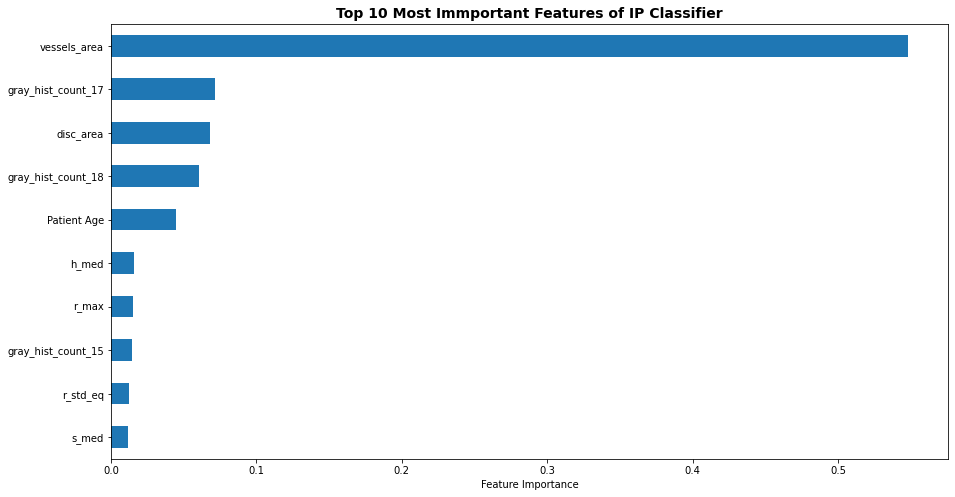

In [70]:
y_feat = clf.feature_importances_
x_feat = X_test.columns
pd.Series(y_feat, index=x_feat).sort_values().tail(10).plot.barh(
    figsize=(15, 8))
plt.title("Top 10 Most Immportant Features of IP Classifier", weight='bold', 
          size=14)
plt.xlabel('Feature Importance');

# Conclusion and Recommendation

TODO: 

# References

TODO: 